In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV


import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all cvisualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'


In [3]:
df = pd.read_csv("../data/infosys/infosys_data_indicators.csv")
df.head()

,Date,Open Price,High,Low,Close Price,Total Traded Quantity,SMA,EWMA5,MiddleBand,UpperBand,LowerBand,RSI,MFI,ForceIndex,ATR,EMV
0,1996-01-01,0.794921,0.796679,0.791015,0.796679,204800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1996-01-02,0.794921,0.798828,0.793457,0.793457,204800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-659.8656,0.005517,NaN
2,1996-01-03,0.798828,0.798828,0.798828,0.798828,102400.0,NaN,NaN,NaN,NaN,NaN,76.926382,NaN,549.9904,0.002685,0.003010
3,1996-01-04,0.791015,0.794921,0.791015,0.793554,307200.0,NaN,0.795381,NaN,NaN,NaN,30.638905,NaN,-1620.1728,0.001953,-0.003725
4,1996-01-05,0.784179,0.784179,0.784179,0.784179,51200.0,0.793339,0.791081,0.793339,0.804531,0.782148,9.760131,NaN,-480.0000,0.001953,-0.003725


In [4]:
df.dropna(inplace=True)

In [5]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

In [6]:
# drop_cols = ['Symbol', 'Total Traded Quantity', 'Open Price', 'High',"Average Trading Price",'52 Week Low','52 Week High','MiddleBand','LowerBand','UpperBand']
temp = df
# drop_cols = ['Symbol', 'Total Traded Quantity', 'Open Price', 'Low', 'High',"Average Trading Price",'MiddleBand','LowerBand','UpperBand','Date']
# drop_cols = ['Low']
drop_cols=["Open Price","High","MiddleBand","UpperBand","LowerBand","Date","Low"]

train_df = train_df.drop(columns=drop_cols)
valid_df = valid_df.drop(columns=drop_cols)
test_df  = test_df.drop(columns=drop_cols)

In [7]:
train_df.head()# drop_cols = ['Symbol', 'Total Traded Quantity', 'Open Price', 'High',"Average Trading Price",'52 Week Low','52 Week High','MiddleBand','LowerBand','UpperBand']
# temp = df
# # drop_cols = ['Symbol', 'Total Traded Quantity', 'Open Price', 'Low', 'High',"Average Trading Price",'MiddleBand','LowerBand','UpperBand','Date']
# # drop_cols = ['Low']
# drop_cols=["Open Price","High","MiddleBand","UpperBand","LowerBand","Date","Low"]

# train_df = train_df.drop(columns=drop_cols)
# valid_df = valid_df.drop(columns=drop_cols)
# test_df  = test_df.drop(columns=drop_cols)

,Close Price,Total Traded Quantity,SMA,EWMA5,RSI,MFI,ForceIndex,ATR,EMV
13,0.776367,204800.0,0.779180,0.778484,42.866588,42.893072,519.9872,0.009277,0.015763
14,0.768554,512000.0,0.775566,0.775167,15.938057,40.613680,-4000.2560,0.005127,-0.008394
15,0.776367,204800.0,0.775273,0.775567,62.744906,40.556280,1600.1024,0.004150,0.003889
16,0.773925,665600.0,0.773808,0.775019,46.544215,35.165373,-1625.3952,0.009277,0.005450
17,0.770507,409600.0,0.773144,0.773514,27.016785,34.661010,-1400.0128,0.015625,-0.026741


In [8]:

cols = ["Close Price"]
y_train = train_df['Close Price'].copy()
X_train = train_df.drop(columns=cols)

y_valid = valid_df['Close Price'].copy()
X_valid = valid_df.drop(columns=cols)

y_test  = test_df['Close Price'].copy()
X_test  = test_df.drop(columns=cols)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3962 entries, 13 to 4277
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Total Traded Quantity  3962 non-null   float64
 1   SMA                    3962 non-null   float64
 2   EWMA5                  3962 non-null   float64
 3   RSI                    3962 non-null   float64
 4   MFI                    3962 non-null   float64
 5   ForceIndex             3962 non-null   float64
 6   ATR                    3962 non-null   float64
 7   EMV                    3962 non-null   float64
dtypes: float64(8)
memory usage: 278.6 KB


In [9]:
# TODO: FIX THE WARNINGS

parameters = {
    'n_estimators': range(100,1000,100),#500
    'learning_rate': [0.001, 0.005, 0.01, 0.05] ,#0.05
    'max_depth': [8, 10, 12, 15,20,32], #8
    'gamma': [0.001, 0.005, 0.01, 0.02],#0.001
    'random_state': [42]
}
','
eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False,random_state=42,silent=True)
clf = GridSearchCV(model, parameters,verbose=False)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')


[10:12:05] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[10:12:05] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[10:12:05] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[10:12:06] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[10:12:06] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[10:12:06] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[10:12:06] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[10:12:07] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[10:12:07] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[10:12:07] WARNING: ../src/learner.cc

KeyboardInterrupt: 

In [ ]:
parameters = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 8,
    # 'gamma':0.001,
    'random_state': 42
}

model = xgb.XGBRegressor(**parameters, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

NameError: name 'xgb' is not defined

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

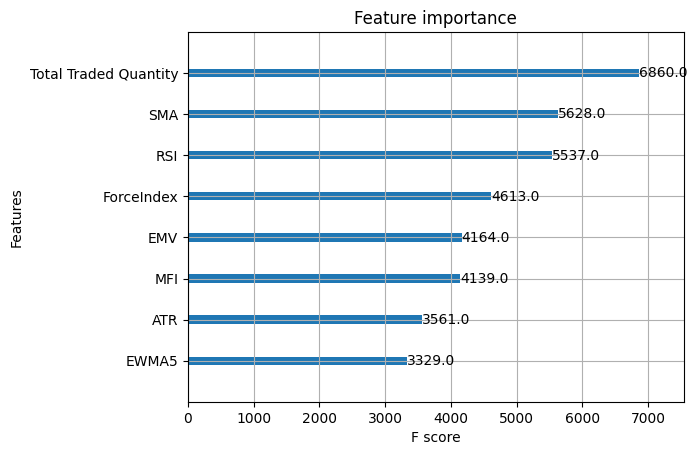

In [ ]:
plot_importance(model)

In [ ]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')


y_true = [583.9  585.8  577.05 571.8  578.2 ]
y_pred = [314.27866 315.93008 309.78928 307.70822 313.54648]


In [ ]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 38775.58691029623


In [ ]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close Price'] = y_pred
predicted_prices.head()

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=temp.index, y=df['Close Price'],
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=predicted_prices['Close Price'],
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=y_pred,
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()